In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans, DBSCAN

### 1. App 可视化

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def get_node2id(file=None):
    if not file:
        file = '../resources/node2id.pkl'
    node2id = pickle.load(open(file, 'rb'))
    print('load node2id from %s, it has %s nodes' % (file, len(node2id)))
    return node2id

In [4]:
node2id = get_node2id()
id2node = {}
for node, val in node2id.items():
    if 25467 > val[0] >= 25413:
        id2node[val[0] - 25413] = node
del node2id
node2id = {}
for id,node in id2node.items():
    node2id[node] = id

load node2id from ../resources/node2id.pkl, it has 25486 nodes


In [5]:
ids = list(id2node.keys())
applist = list(id2node.values())

In [6]:
def get_embeddings(file_name, node2id):  # 每个节点的embedding向量，给dnn的lookup用
    """
    embeddings的节点有的存成id, 有的是名称需要node2id
    :param file_name: embeddings file
    :param node2id: node:[id, type, count]
    :return:
    """
    embeddings_file = os.path.join("../network_embedding/embeddings_output/", file_name)
    with open(embeddings_file, 'r') as f:
        shape = tuple(map(int, f.readline().split()))
        print('node: %s, embedding_size: %s' % shape)
        embeddings = np.zeros((54, 128))
        for line in f:
            splits = line.split()
            if line.startswith('金山'):
                embeddings[node2id['金山WPS OFFICE手机版']] = list(map(float, splits[2:]))
            elif splits[0] in node2id:
                embeddings[node2id[splits[0]]] = list(map(float, splits[1:]))
            elif splits[0].isdigit() and int(splits[0])-25413 in ids:
                embeddings[int(splits[0]) - 25413] = list(map(float, splits[1:]))
    return embeddings

In [7]:
deepwalk_embeddings = get_embeddings('deepwalk.embeddings', node2id)
hin2vec_embeddings = get_embeddings('node_vectors.txt', node2id)

node: 25486, embedding_size: 128
node: 25486, embedding_size: 128


In [17]:
from matplotlib.font_manager import FontProperties
font=FontProperties(fname='/Library/Fonts/Songti.ttc', size=5)

def reduction_and_plot(model, data, file):
#     xmin, xmax = np.min(data, axis=1, keepdims=True), np.max(data, axis=1, keepdims=True)
#     data = (data - xmin)/(xmax - xmin)
#     data = data/np.sqrt(np.sum(np.square(data), axis=1, keepdims=True))
    data = model(n_components=2).fit_transform(data)
    
    fig = plt.figure()
    plt.scatter(data[:, 0], data[:, 1], s=0.2)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(id2node[i]), fontproperties=font,)
    #                  color=plt.cm.Set1(label[i] / 10.),
#                      fontdict={'weight': 'bold', 'size': 10})
    plt.savefig(file, dpi=400)
    plt.show()

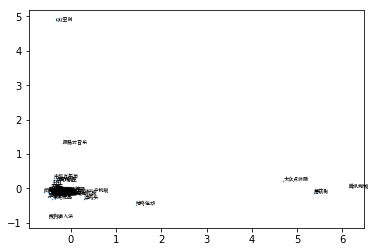

In [19]:
reduction_and_plot(PCA, deepwalk_embeddings, 'deepwalk.jpg')
!open deepwalk.jpg

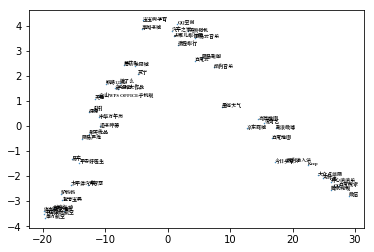

In [18]:
reduction_and_plot(PCA, hin2vec_embeddings, 'hin2vec.jpg')
!open hin2vec.jpg

In [20]:
import pandas as pd

In [38]:
data = pd.read_csv('/Users/chenhui/works/datasets/nfp/data0117.csv')
data = data.loc[:, ['app', 'app_cat']]
data.drop_duplicates(inplace=True)
data.to_csv('../resources/app_cat.csv', index=False)

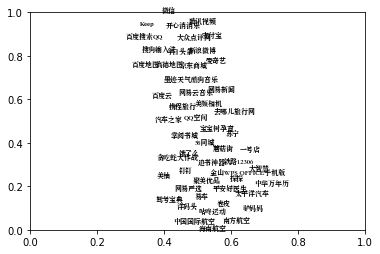

In [41]:
reduction_and_plot(hin2vec_embeddings, 'hin2vec.jpg')

In [42]:
node2id

{'58同城': 38,
 'Keep': 11,
 'QQ': 0,
 'QQ空间': 29,
 '一号店': 25,
 '中华万年历': 35,
 '中国国际航空': 53,
 '京东商城': 19,
 '今日头条': 8,
 '南方航空': 40,
 '卷皮': 48,
 '去哪儿旅行网': 32,
 '咕咚运动': 51,
 '墨迹天气': 23,
 '大众点评网': 9,
 '大智慧': 37,
 '太平洋汽车': 33,
 '宝宝树孕育': 28,
 '平安好医生': 31,
 '开心消消乐': 2,
 '微信': 1,
 '掌阅书城': 27,
 '探探': 47,
 '搜狗输入法': 12,
 '携程旅行': 20,
 '支付宝': 14,
 '新浪微博': 3,
 '易车': 45,
 '汽车之家': 5,
 '洋码头': 49,
 '海南航空': 52,
 '爱奇艺': 18,
 '百度云': 21,
 '百度地图': 7,
 '百度搜索': 4,
 '网易严选': 44,
 '网易云音乐': 10,
 '网易新闻': 15,
 '美柚': 43,
 '美颜相机': 26,
 '聚美优品': 22,
 '腾讯视频': 6,
 '苏宁': 17,
 '蘑菇街': 30,
 '贪吃蛇大作战': 24,
 '追书神器': 34,
 '酷狗音乐': 16,
 '金山WPS OFFICE手机版': 46,
 '钉钉': 42,
 '铁路12306': 39,
 '饿了么': 36,
 '驴妈妈': 41,
 '驾考宝典': 50,
 '高德地图': 13}

In [44]:
len(node2id)

54

### 2. metapath聚类

In [2]:
metapath = []
vectors = []
with open('../network_embedding/embeddings_output/metapath_vectors.txt') as f:
    for line in f:
        splits = line.split()
        if len(splits) == 2:
            print('metapath: %s, embedding_size: %s' % (splits[0], splits[1]))
            continue
        metapath.append(splits[0])
        vectors.append(list(map(float, splits[1:])))

metapath: 30, embedding_size: 128


In [31]:
kmeans = KMeans(n_clusters=5).fit(vectors)
kmeans.labels_

array([4, 3, 0, 2, 4, 3, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [10]:
metapath

['U-A',
 'A-U',
 'A-U,U-A',
 'U-A,A-U',
 'U-A,A-U,U-A',
 'A-U,U-A,A-U',
 'A-U,U-A,A-U,U-A',
 'U-A,A-U,U-A,A-U',
 'C-A',
 'C-A,A-U',
 'C-A,A-U,U-A',
 'A-C',
 'A-C,C-A',
 'C-A,A-U,U-A,A-U',
 'U-A,A-C',
 'U-A,A-C,C-A',
 'A-U,U-A,A-C',
 'A-U,U-A,A-C,C-A',
 'A-C,C-A,A-U',
 'A-C,C-A,A-U,U-A',
 'U-A,A-U,U-A,A-C',
 'U-A,A-C,C-A,A-U',
 'C-A,A-C',
 'C-A,A-C,C-A',
 'A-C,C-A,A-C',
 'A-C,C-A,A-C,C-A',
 'C-A,A-C,C-A,A-U',
 'U-A,A-C,C-A,A-C',
 'C-A,A-U,U-A,A-C',
 'C-A,A-C,C-A,A-C']

In [23]:
cluster = DBSCAN(eps=3, min_samples=2).fit(vectors)
cluster.labels_

array([-1, -1,  0, -1, -1, -1,  0, -1,  1,  2,  1, -1,  2,  2,  3,  3, -1,
        2,  2,  2,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2])

In [28]:
def match(paths, labels):
    d = {}
    for i in range(len(paths)):
        path = paths[i]
        label = labels[i]
        if label not in d:
            d[label] = []
        d[label].append(path)
    for k, v in d.items():
        print(k, ':', v)

In [29]:
match(metapath, cluster.labels_)

-1 : ['U-A', 'A-U', 'U-A,A-U', 'U-A,A-U,U-A', 'A-U,U-A,A-U', 'U-A,A-U,U-A,A-U', 'A-C', 'A-U,U-A,A-C']
0 : ['A-U,U-A', 'A-U,U-A,A-U,U-A']
1 : ['C-A', 'C-A,A-U,U-A']
2 : ['C-A,A-U', 'A-C,C-A', 'C-A,A-U,U-A,A-U', 'A-U,U-A,A-C,C-A', 'A-C,C-A,A-U', 'A-C,C-A,A-U,U-A', 'C-A,A-C', 'C-A,A-C,C-A', 'A-C,C-A,A-C', 'A-C,C-A,A-C,C-A', 'C-A,A-C,C-A,A-U', 'U-A,A-C,C-A,A-C', 'C-A,A-U,U-A,A-C', 'C-A,A-C,C-A,A-C']
3 : ['U-A,A-C', 'U-A,A-C,C-A', 'U-A,A-U,U-A,A-C', 'U-A,A-C,C-A,A-U']


In [32]:
match(metapath, kmeans.labels_)

4 : ['U-A', 'U-A,A-U,U-A']
3 : ['A-U', 'A-U,U-A,A-U']
0 : ['A-U,U-A', 'A-U,U-A,A-U,U-A']
2 : ['U-A,A-U', 'U-A,A-U,U-A,A-U']
1 : ['C-A', 'C-A,A-U', 'C-A,A-U,U-A', 'A-C', 'A-C,C-A', 'C-A,A-U,U-A,A-U', 'U-A,A-C', 'U-A,A-C,C-A', 'A-U,U-A,A-C', 'A-U,U-A,A-C,C-A', 'A-C,C-A,A-U', 'A-C,C-A,A-U,U-A', 'U-A,A-U,U-A,A-C', 'U-A,A-C,C-A,A-U', 'C-A,A-C', 'C-A,A-C,C-A', 'A-C,C-A,A-C', 'A-C,C-A,A-C,C-A', 'C-A,A-C,C-A,A-U', 'U-A,A-C,C-A,A-C', 'C-A,A-U,U-A,A-C', 'C-A,A-C,C-A,A-C']
